In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

## Read in netCDF data

In [2]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
#dataset = 'data10102019'
dataset = "01052014"
f = netcdf_file(f"{dataset}.nc")
f.variables

{'ugos': <scipy.io._netcdf.netcdf_variable at 0x7feecdf70370>,
 'vgos': <scipy.io._netcdf.netcdf_variable at 0x7feea5816700>,
 'vgosa': <scipy.io._netcdf.netcdf_variable at 0x7feea5816730>,
 'crs': <scipy.io._netcdf.netcdf_variable at 0x7feea58167c0>,
 'err_vgosa': <scipy.io._netcdf.netcdf_variable at 0x7feea5816850>,
 'latitude': <scipy.io._netcdf.netcdf_variable at 0x7feea5816910>,
 'sla': <scipy.io._netcdf.netcdf_variable at 0x7feea58169a0>,
 'ugosa': <scipy.io._netcdf.netcdf_variable at 0x7feea5816a30>,
 'flag_ice': <scipy.io._netcdf.netcdf_variable at 0x7feea5816b80>,
 'adt': <scipy.io._netcdf.netcdf_variable at 0x7feea5816c10>,
 'err_ugosa': <scipy.io._netcdf.netcdf_variable at 0x7feea5816cd0>,
 'time': <scipy.io._netcdf.netcdf_variable at 0x7feea5816d60>,
 'longitude': <scipy.io._netcdf.netcdf_variable at 0x7feea5816dc0>,
 'err_sla': <scipy.io._netcdf.netcdf_variable at 0x7feea5816e50>}

In [3]:
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_x = f.variables['ugos'].data.squeeze()
print(vel_x.shape[0])
vel_y = f.variables['vgos'].data.squeeze()
print(vel_y.shape)
from common_functions import interpolate_missing_point

imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)
imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)

320
(320, 81)


In [4]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
from scipy.spatial.distance import euclidean


# first build an interpolator over the x and y velocity
# for now dont use any proper coordinates just [0,m]*[0,n]
m,n = imputed_vel_x.shape
i = np.linspace(0, m, m)
j = np.linspace(0, n, n)
method = "linear"

interp_vel_x = RegularGridInterpolator((i, j), imputed_vel_x, method=method)
interp_vel_y = RegularGridInterpolator((i, j), imputed_vel_y, method=method)

def rhs(t, x):
    return [interp_vel_x(x).squeeze(), interp_vel_y(x).squeeze()]
    
def streamline(i,j, *, steps, step_size, dist_tol, winding_tol):
    #print(i,j, flush=True)
    winding_angle = 0
    theta_prev = 0
    closed = False
    
    start_i = i
    start_j = j
    
    # streamline path
    trajectory = [[i,j]]
    
    for k in range(steps):
        try:
            # get velocities
            v = rhs(0,[i,j])
        except:
            # stream line leaves domain
            break
        
        # integrate
        i += step_size*v[1]
        j += step_size*v[0]
        
        # get angle
        theta = np.arctan2(v[1], v[0])
        
        if k > 1:
            winding_angle += theta - theta_prev
           
        if k > 100 and (dist:=euclidean([i,j],[start_i,start_j])) < dist_tol:
            closed = True
            break
            
            
        theta_prev = theta
        trajectory.append([i,j])
    
    if (winding_angle % (2*np.pi) < winding_tol or winding_angle % (-2*np.pi) < winding_tol) and closed:
        print(f"{dist=} {winding_angle=} {closed=}")
        return np.asarray(trajectory).T
    return None
        
        
from multiprocessing import Pool
from functools import partial
from itertools import product

step = 5

i_points = range(0, imputed_vel_x.shape[0], step)
j_points = range(0, imputed_vel_x.shape[1], step)

with Pool() as p:
    func = partial(streamline, steps=5000, step_size=0.1, dist_tol=0.3, winding_tol=0.3)
    
    res = p.starmap(func, product(i_points,j_points))

eddies = []

for result in res:
    if result is not None:
        eddies.append(np.mean(result, axis=-1))

eddies = np.asarray(eddies)


dist=0.20173686431707138 winding_angle=-0.18019799236270467 closed=Truedist=0.20765786192404617 winding_angle=0.16679167332127165 closed=True

dist=0.11516472575929965 winding_angle=-0.11416307539152443 closed=True
dist=0.29816887472502746 winding_angle=0.008595062968828504 closed=True
dist=0.2428318249602041 winding_angle=-0.16062359417928662 closed=True
dist=0.21355888644215512 winding_angle=0.032168952834180975 closed=True
dist=0.2888325900819441 winding_angle=0.07138865178609821 closed=True
dist=0.2980195976122087 winding_angle=0.11901718523585145 closed=True
dist=0.29759593571812387 winding_angle=-0.18424314468882852 closed=True
dist=0.2974432686806307 winding_angle=-0.20816177171925476 closed=True
dist=0.2948891534424551 winding_angle=-0.2933897597386547 closed=True
dist=0.2930831803778071 winding_angle=-0.020939424702667075 closed=True
dist=0.28513612928820165 winding_angle=0.05422506972900765 closed=True
dist=0.29991519449576065 winding_angle=-0.37047391074652725 closed=True
di

dist=0.2845654488186505 winding_angle=0.018214653066312425 closed=True
dist=0.2929004911264933 winding_angle=-0.15733188140841736 closed=True
dist=0.29943046359743003 winding_angle=-0.08251108314867128 closed=True
dist=0.12448365518357962 winding_angle=-0.07690045018097802 closed=True
dist=0.2953791692896943 winding_angle=-0.24669852140874915 closed=True
dist=0.10789886585184683 winding_angle=0.6036141350292727 closed=True
dist=0.2922145843493177 winding_angle=0.10980144395231717 closed=True
dist=0.2708001847933189 winding_angle=-0.007158809139761899 closed=True
dist=0.18947266597405454 winding_angle=0.15188807887272016 closed=True
dist=0.29248723401140164 winding_angle=0.1949837217091437 closed=True
dist=0.2894918436121028 winding_angle=-0.17877153694767856 closed=True
dist=0.29929187149702086 winding_angle=1.2530381856152617 closed=True
dist=0.29865592469597546 winding_angle=0.053089271479238975 closed=True
dist=0.29670155993879904 winding_angle=-0.39576585166677003 closed=True
dist=

<IPython.core.display.Javascript object>


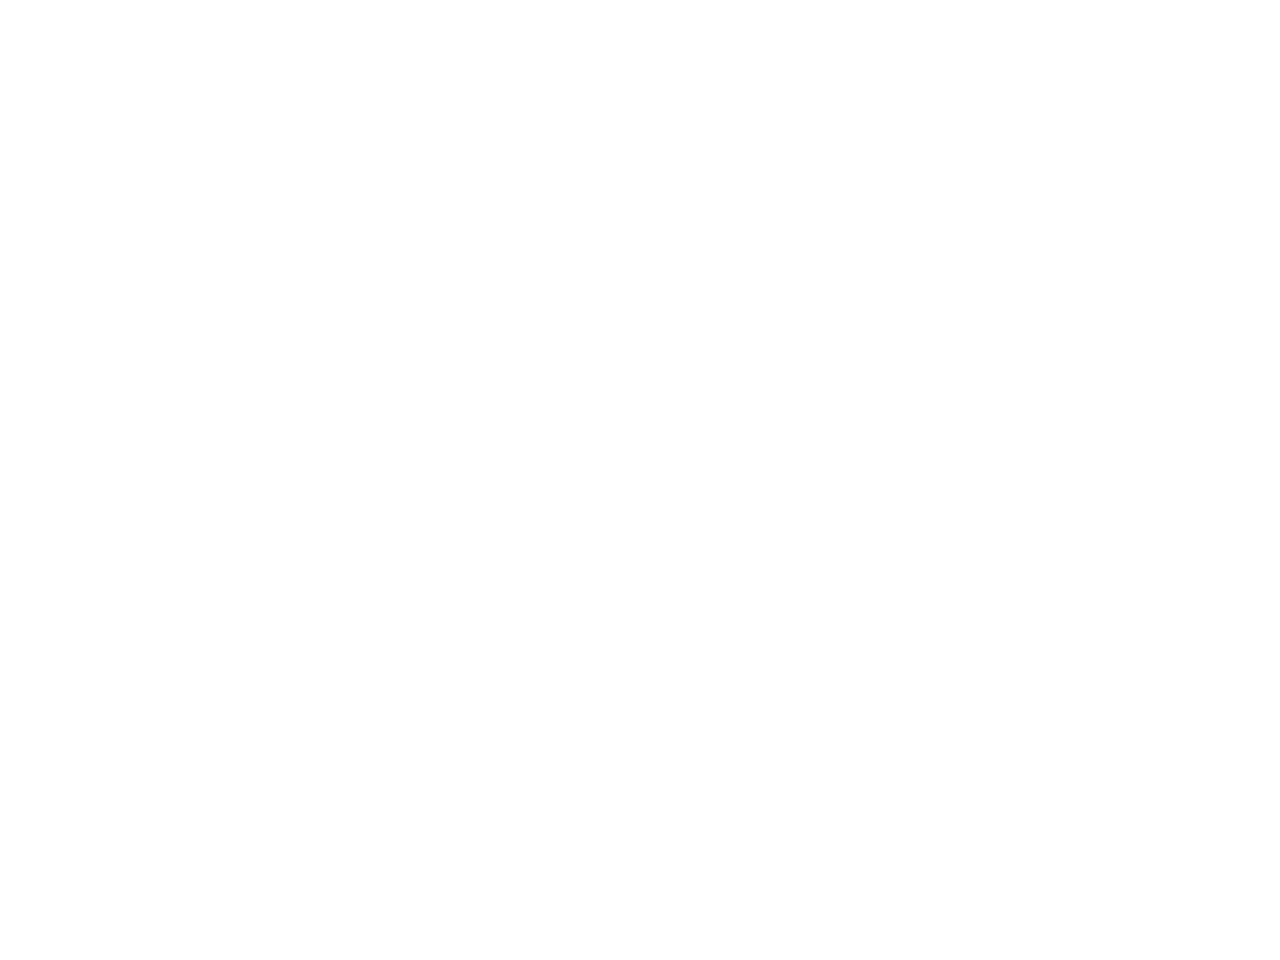

In [5]:
plt.figure(dpi = 200)
plt.imshow(np.hypot(imputed_vel_x, imputed_vel_y), origin='lower',)
plt.plot(eddies[:,1], eddies[:,0], 'w.', markersize=5, label="Eddy Centre")
plt.quiver(imputed_vel_x, imputed_vel_y, color='r', scale=5, zorder=2)

In [7]:
from scipy.interpolate import RegularGridInterpolator

m,n = imputed_vel_x.shape
i = np.linspace(0, m, m)
j = np.linspace(0, n, n)
method = "linear"

latm, longm = np.meshgrid(lat, long, indexing='ij')

interp_lat = RegularGridInterpolator((i, j), latm, method=method)
interp_long = RegularGridInterpolator((i, j), longm, method=method)

np.savetxt(f"windingangle-{dataset}.csv",np.column_stack([interp_lat(eddies), interp_long(eddies)]), delimiter=',')